# Импорт библиотек и первичное преобразование данных

In [ ]:
# Импорт нужных библиотек
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

In [ ]:
# Чтение файла
df = pd.read_csv('Temp.csv')
# Преобразуем дату к виду date-time
df.Date = pd.to_datetime(df.Date)
# Переносим преобразованную дату в индекс
df.set_index("Date", inplace = True)
df = df.iloc[0:730]
df.head(5)

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<Axes: xlabel='Date'>

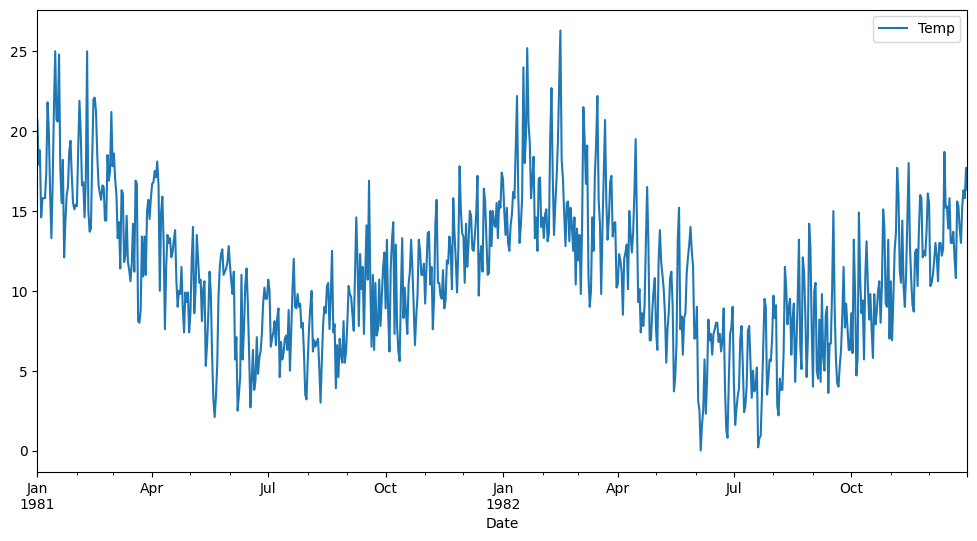

In [ ]:
# Строим график исходных данных
df.plot(figsize=(12,6))

<Axes: xlabel='Date'>

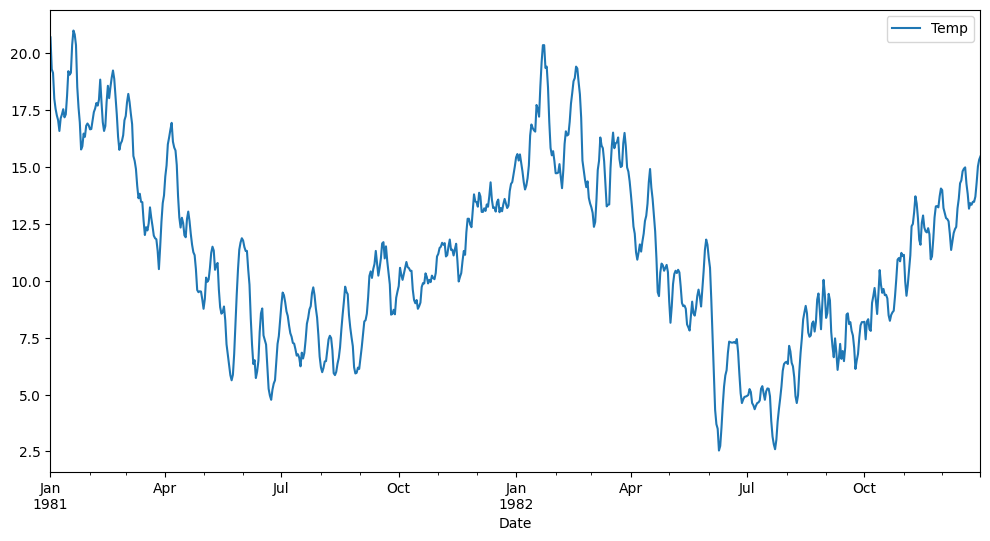

In [ ]:
# Строим график данных, устреднённый по неделям
df = df[['Temp']].rolling('7d').mean()
df.plot(figsize=(12,6))

# Анализ данных

О величине расброса во временном ряду может сказать стандартное отклонение, однако по его абсолютному значению нельзя сказать насколько оно высокое, потому что это зависит от самих данных.

Поэтому, чтобы понять, является ли СКО высоким или низким, рассчитывается коэффициент вариации, который равен отношению СКО к среднему значению выборки.

Чем выше коэффициент вариации, тем выше СКО относительно среднего значения.

In [ ]:
# Получим основные статистики временного ряда
df.describe()

,Temp
count,730.000000
mean,11.162470
std,3.944044
min,2.542857
25%,8.203571
50%,10.857143
75%,13.810714
max,21.000000


In [ ]:
# Рассчитаем коэффициент вариации, делаем вывод, что разброс в наших данных небольшой
print('Коэффициент вариации:', df.std()/df.mean())

Коэффициент вариации: Temp    0.353331
dtype: float64


array([[<Axes: title={'center': 'Temp'}>]], dtype=object)

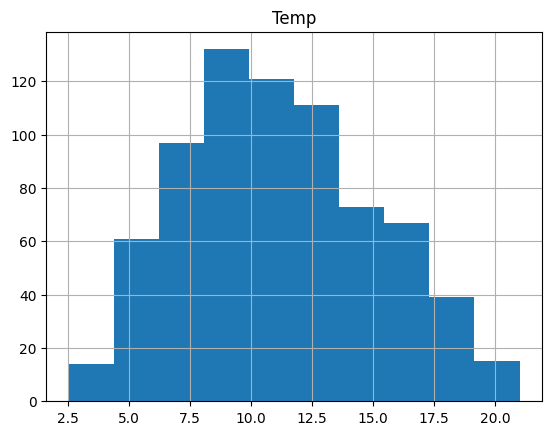

In [ ]:
# Построим гистограмму распределения данных временного ряда
df.hist()

In [ ]:
# Проведём тест на проверку соответствия распределения нормальному закону
# H0 - данные распределены нормально
import scipy

a = 0.05
stat, p = scipy.stats.shapiro(df['Temp'])
print(f'p-value:{p}')

if p < a:
  print('Данные не соответствуют нормальному распределению')
else:
  print('Данные распределены нормально')

p-value:6.592034083041654e-07
Данные не соответствуют нормальному распределению


Важной характеристикой временного ряда является его стационарность/нестационарность, для выяснения этой характеристики используется обобщённый тест Дикки-Фуллера на стационарность.

H0 - ряд нестационарен

In [ ]:
# Проведём тест на стационарность
# H0 - ряд не стационарный
# Импортируем необходимую функцию
from statsmodels.tsa.stattools import adfuller

# Задаём уровень значимости
a = 0.05
# передадим ей столбец с данными о средней температуре
adf_test = adfuller(df['Temp'])
p_value = adf_test[1]

print('p-value:', p_value)
if p_value < a:
  print('Ряд стационарен')
else:
  print('Ряд не стационарен')


p-value: 0.287927662922183
Ряд не стационарен


Если ряд не стационарен, то привести его к стационарному виду может помочь разность ряда

<Axes: xlabel='Date'>

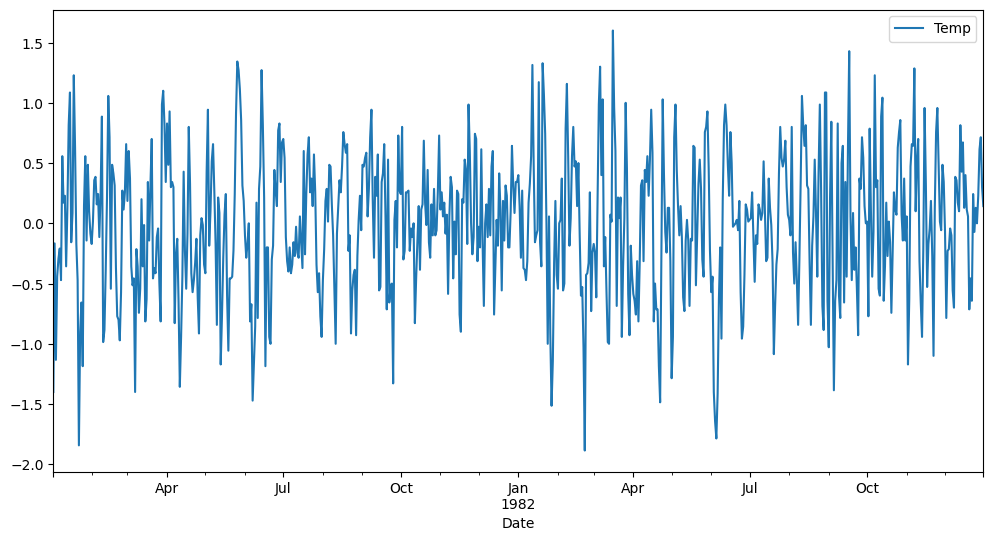

In [ ]:
# Найдём первую разность для нашего временного ряда и построим получившийся график
diff_1 = df.diff().dropna()
diff_1.plot(figsize=(12,6))

In [ ]:
# Ещё раз проведём тест
# Задаём уровень значимости
a = 0.05
# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(diff_1['Temp'])
p_value = adf_test[1]

print('p-value:', p_value)
if p_value < a:
  print('Ряд стационарен')
else:
  print('Ряд не стационарен')

p-value: 2.857952401635775e-14
Ряд стационарен


<Axes: xlabel='Date'>

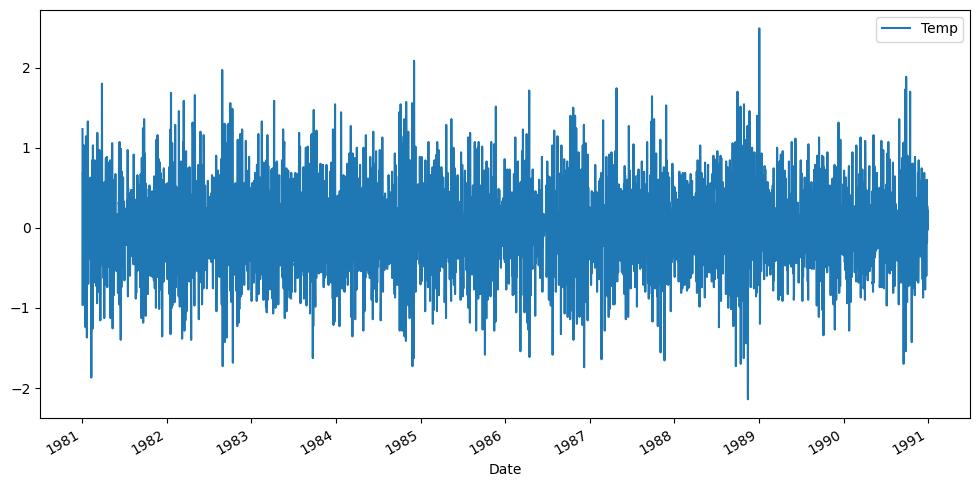

In [ ]:
# Дополнительно найдём вторую производную ряда и построим её график
diff_2 = diff_1.diff(periods=1).dropna()
diff_2.plot(figsize=(12,6))

# Построение модели ARIMA

Чтобы построить модель ARIMA нужно знать её порядок, состоящий из трёх параметров:

* p - порядок компоненты AR
* d - порядок интегрирования ряда I
* q - порядок компоненты MA

Мы уже получили порядок компоненты d, теперь нужно определить p и q.

Для нахождения порядка q нужно построить автокорреляционную функцию (ACF), с её помощью мы определим количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA, это и будет значение порядка q

Для нахождения параметра p используется частичная автокорреляционная функция, по её графику можно определить максимальный номер коэффициента, сильно отличный от 0 в модели AR

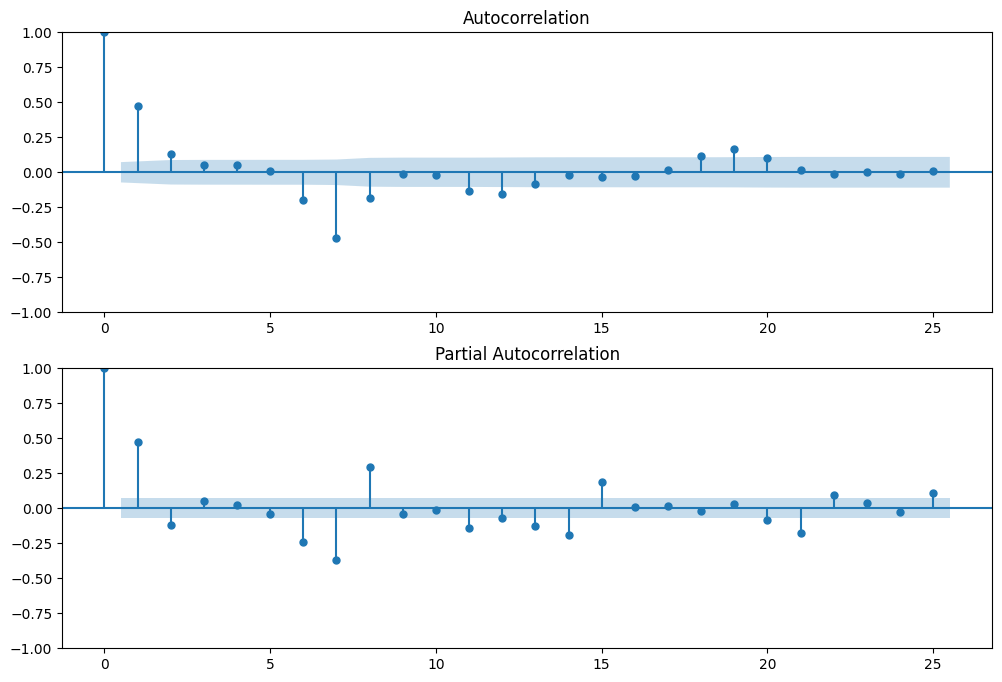

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_1.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_1, lags=25, ax=ax2)

Выделим тренировочные и тестовые данные

In [ ]:
train = df[:500]
val = df[500:600]
test = df[600:]

Посмотрим на них на графике

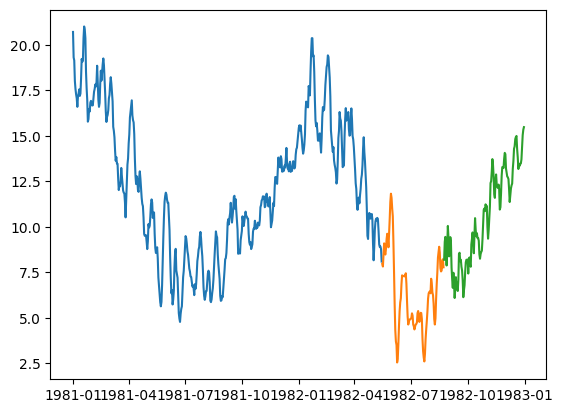

In [ ]:
plt.plot(train)
plt.plot(val)
plt.plot(test)

Далее обучаем модель, здесь самое важное - правильно подобрать гиперапараметры, этот процесс довольно сложен и пока используем готовые значения

In [ ]:
model = sm.tsa.ARIMA(train, order=(9,0,1)).fit()

Сделаем прогноз

In [ ]:
# prediction = pd.DataFrame(model.predict(val[['Temp']]),index=val.index)
# prediction.columns = ['Temp']

In [ ]:
prediction

,Temp
Date,
1982-05-16,NaN
1982-05-17,NaN
1982-05-18,NaN
1982-05-19,NaN
1982-05-20,NaN
...,...
1982-08-19,NaN
1982-08-20,NaN
1982-08-21,NaN


In [ ]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
# и закончится в конце тестового
end = len(train) + len(test) -1
# Предсказываем результат
pred = model.predict(start, end)

Посчитаем метрику

In [ ]:
from sklearn.metrics import r2_score
pred = model.predict(start, end)
r2 = r2_score(test, pred)
print('R2: %1.2f' % r2)

R2: 0.49


Построим график сравнения предсказанных значений и реальных

<Axes: >

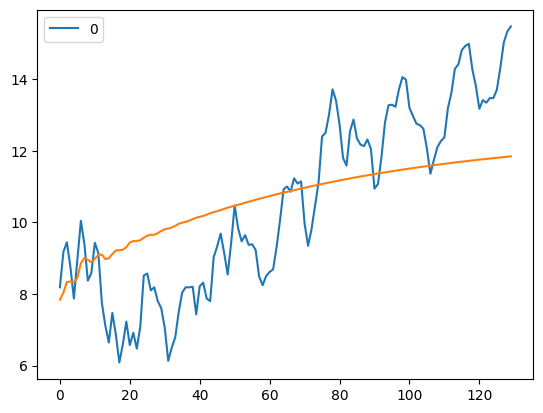

In [ ]:
import seaborn as sns
sns.lineplot(data = test.values)
sns.lineplot(data = pred.values)

Подбор параметров для моделей семейства ARMA явдяется нетривиальной задачей, поэтому для упрощения подбора можно использовать критейрий Акаике, он оценивает то, насколько хорошо модель подходит под данные.

Модель обучается на различных комбинациях параметров и проверяется критерием, наилучшей комбинацией будет та, при которой критерий наименьший.

In [ ]:
# прогнозный период с конца имеющихся данных
start = len(val)

# и закончится 36 месяцев спустя
end = (len(val) - 1) + 10 * 12

# теперь построим прогноз на три года вперед
forecast = model.predict(start, end)

# посмотрим на весь 1963 год
# forecast

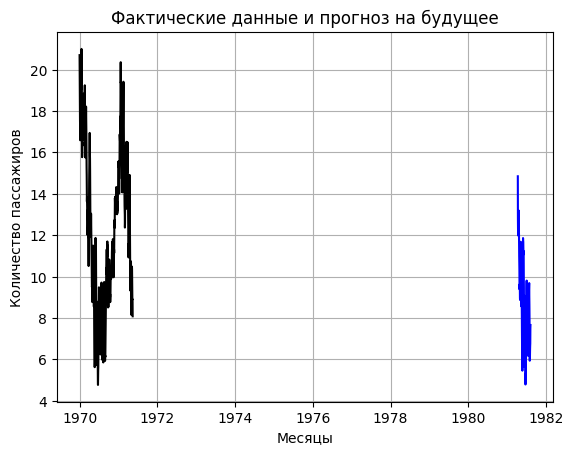

In [ ]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(train.values, color = 'black')
plt.plot(forecast, color = 'blue')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")
# import itertools

# p = range(0,10)
# d = q = range(0,3)

# pdq = list(itertools.product(p, d, q))
# best_pdq = (0,0,0)
# best_aic = np.inf
# for params in pdq:
#   model_test = sm.tsa.ARIMA(train, order = params)
#   result_test = model_test.fit()
#   if result_test.aic < best_aic:
#     best_pdq = params
#     best_aic = result_test.aic
# print(best_pdq, best_aic)

# Проверка оптимальности

Проверить оптимальность модели можно при помощи встроенных процедур. С момощью метода summary() можно получить следующую таблицу.

Здесь больше всего нас интересует таблица коэффициентов. Столбец coef показывает влияние каждого параметра на временной ряд, а P>|z| — значимость. Чем ближе значение P>|z| к нулю, тем выше значимость.

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                  500
Model:                 ARIMA(9, 0, 1)   Log Likelihood                -289.377
Date:                Sun, 28 Jan 2024   AIC                            602.755
Time:                        10:40:54   BIC                            653.330
Sample:                    01-01-1981   HQIC                           622.600
                         - 05-15-1982                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5203      1.898      6.595      0.000       8.800      16.241
ar.L1          1.3737      0.140      9.840      0.000       1.100       1.647
ar.L2         -0.3419      0.197     -1.737      0.0

Другой метод для оценки модели - plot_diagnostics(), с его помощью мы получаем 4 графика, которые говорят об остатках модели (то есть о тех данных, которые не имели вклад в обучение)

Модель работает достаточно хорошо, если остатки модели некоррелированы и распределяются с нулевым средним значением

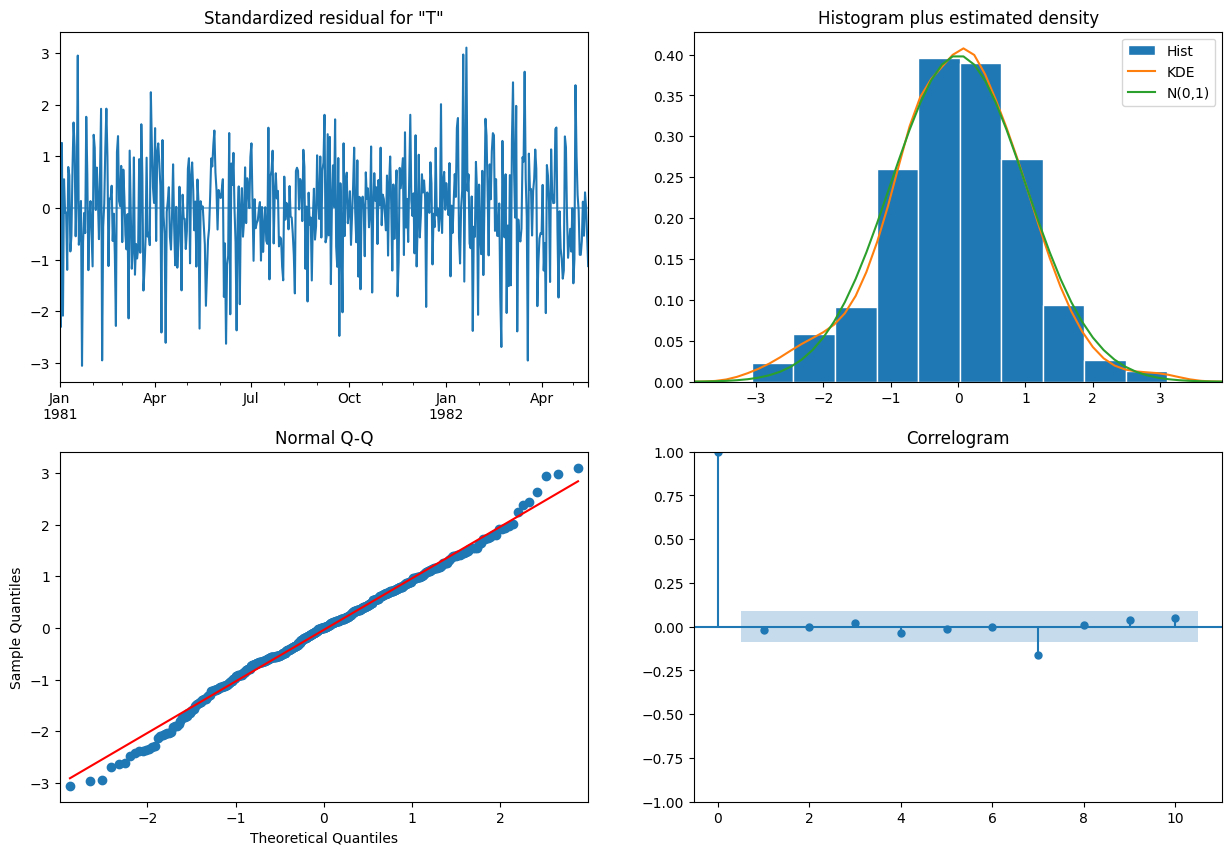

In [ ]:
model.plot_diagnostics(figsize=(15, 10))
plt.show()

заготовка по полному перебору параметров для SARIMAX

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")
# import itertools

# p = range(0,10)
# d = q = range(0,3)
# pdq = list(itertools.product(p, d, q))
# best_pdq = (0,0,0)

# P = range(2, 10)
# D = Q = range(2, 3)
# s = range(2, 5)
# PDQs = list(itertools.product(P, D, Q, s))
# best_PDQs = (0, 0, 0, 0)

# best_aic = np.inf
# for params_1 in pdq:
#   for params_2 in PDQs:
#     model_test = sm.tsa.ARIMA(train_data, order = params_1, seasonal_order = params_2 )
#     result_test = model_test.fit()
#     if result_test.aic < best_aic:
#       best_pdq = params_1
#       best_PDQs = params_2
#       best_aic = result_test.aic
# print(best_pdq, best_aic)